Лабораторная работа №6. Применение сверточных нейронных сетей (многоклассовая классификация)


In [1]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import scipy.io
from sklearn.model_selection import train_test_split
import tarfile
from six.moves import cPickle as pickle
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

In [2]:
def read_images(filename):
    images = []
    with open(filename) as f:
        f.readline()
        for line in f:
            label, *values = line.strip().split(',')
            image = np.array([float(v) for v in values]) / 255
            image.resize((28, 28, 1))
            images.append((int(label), image))

    labels = [p[0] for p in images]
    images = [p[1] for p in images]
    return np.array(labels), np.array(images)

test_labels, test_images = read_images("../data/sign_mnist/sign_mnist_test.csv")
train_labels, train_images = read_images("../data/sign_mnist/sign_mnist_train.csv")
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels)

print(len(train_images), len(train_labels), len(test_images), len(test_labels), len(valid_images), len(valid_labels))

20591 20591 7172 7172 6864 6864


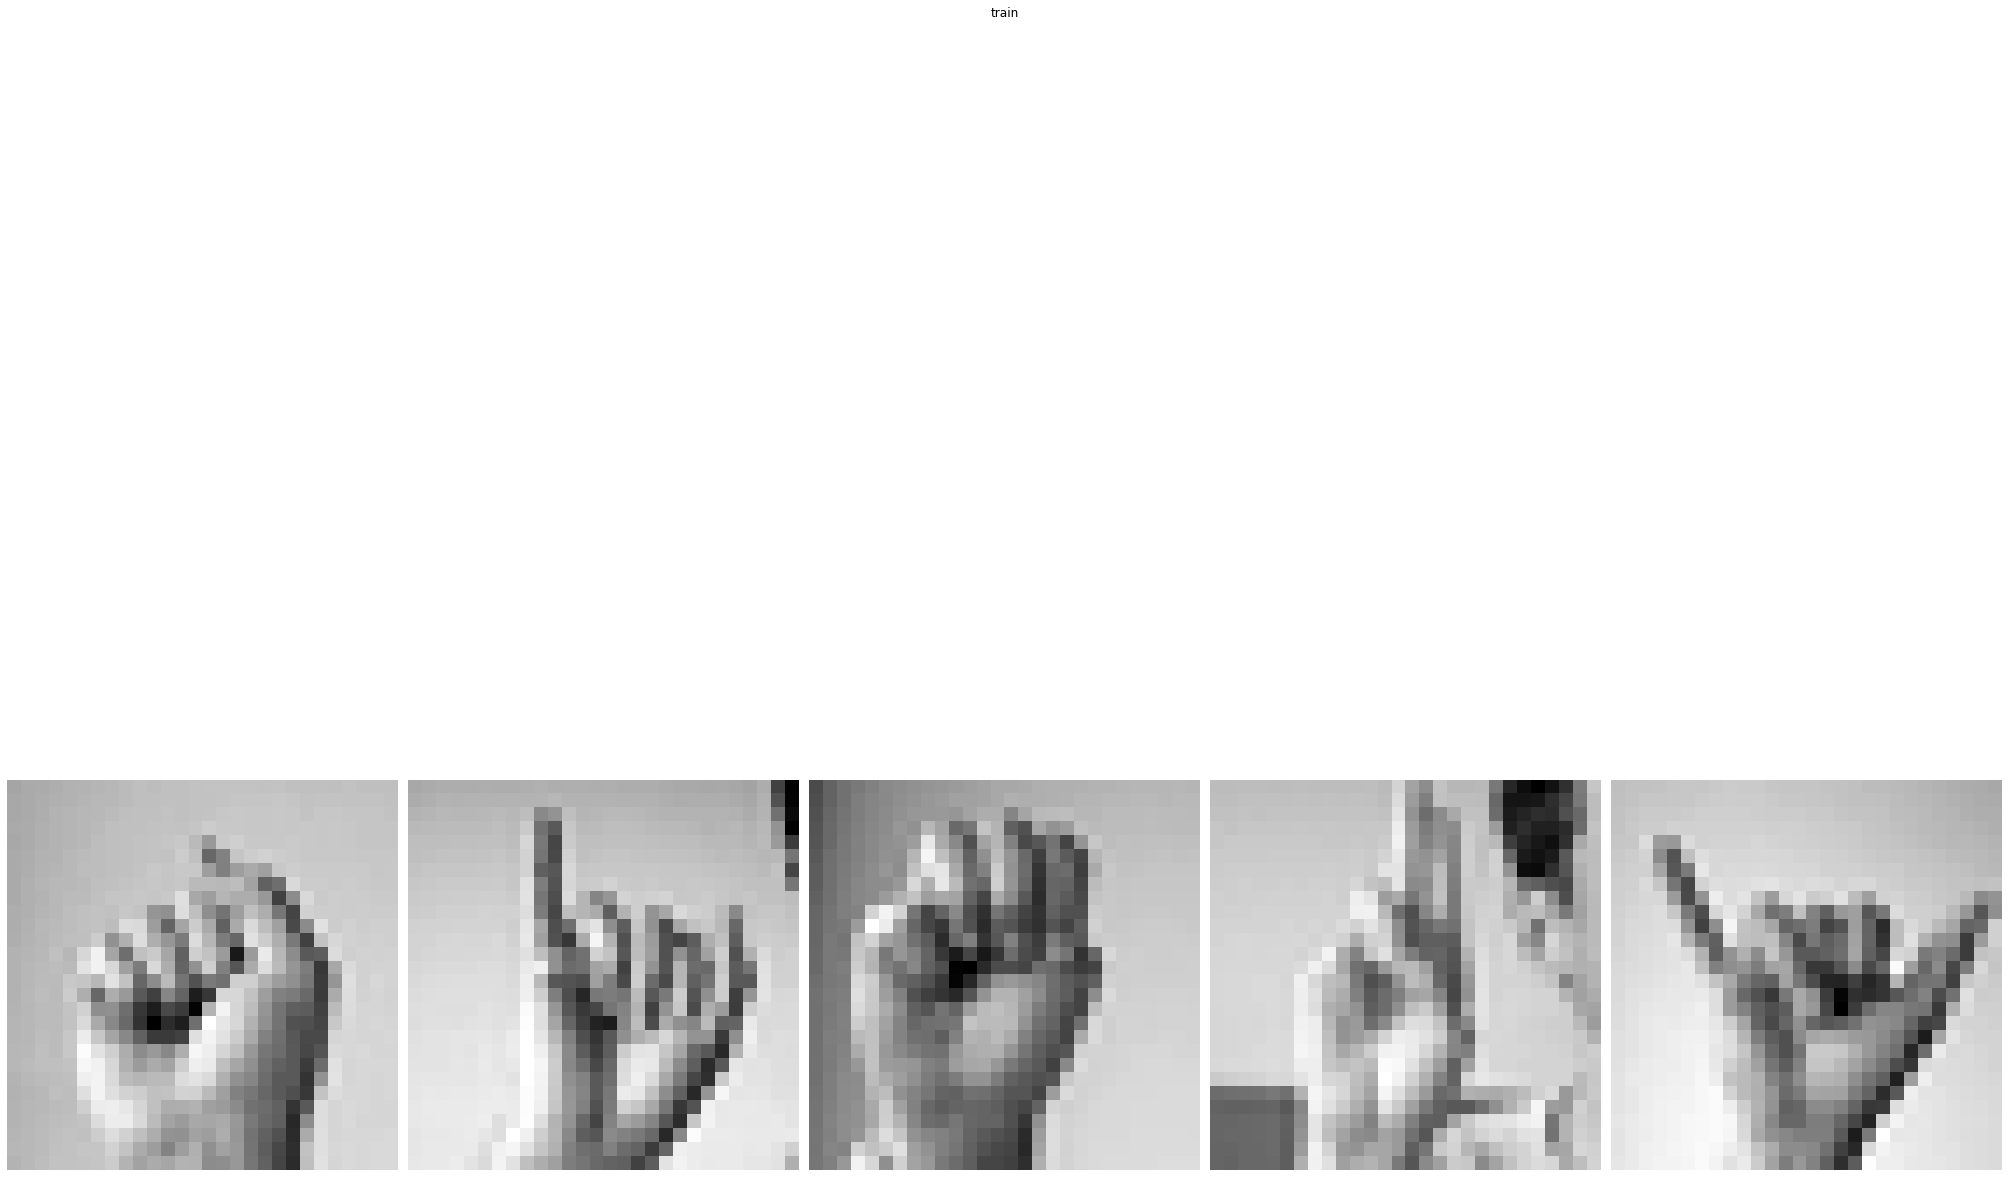

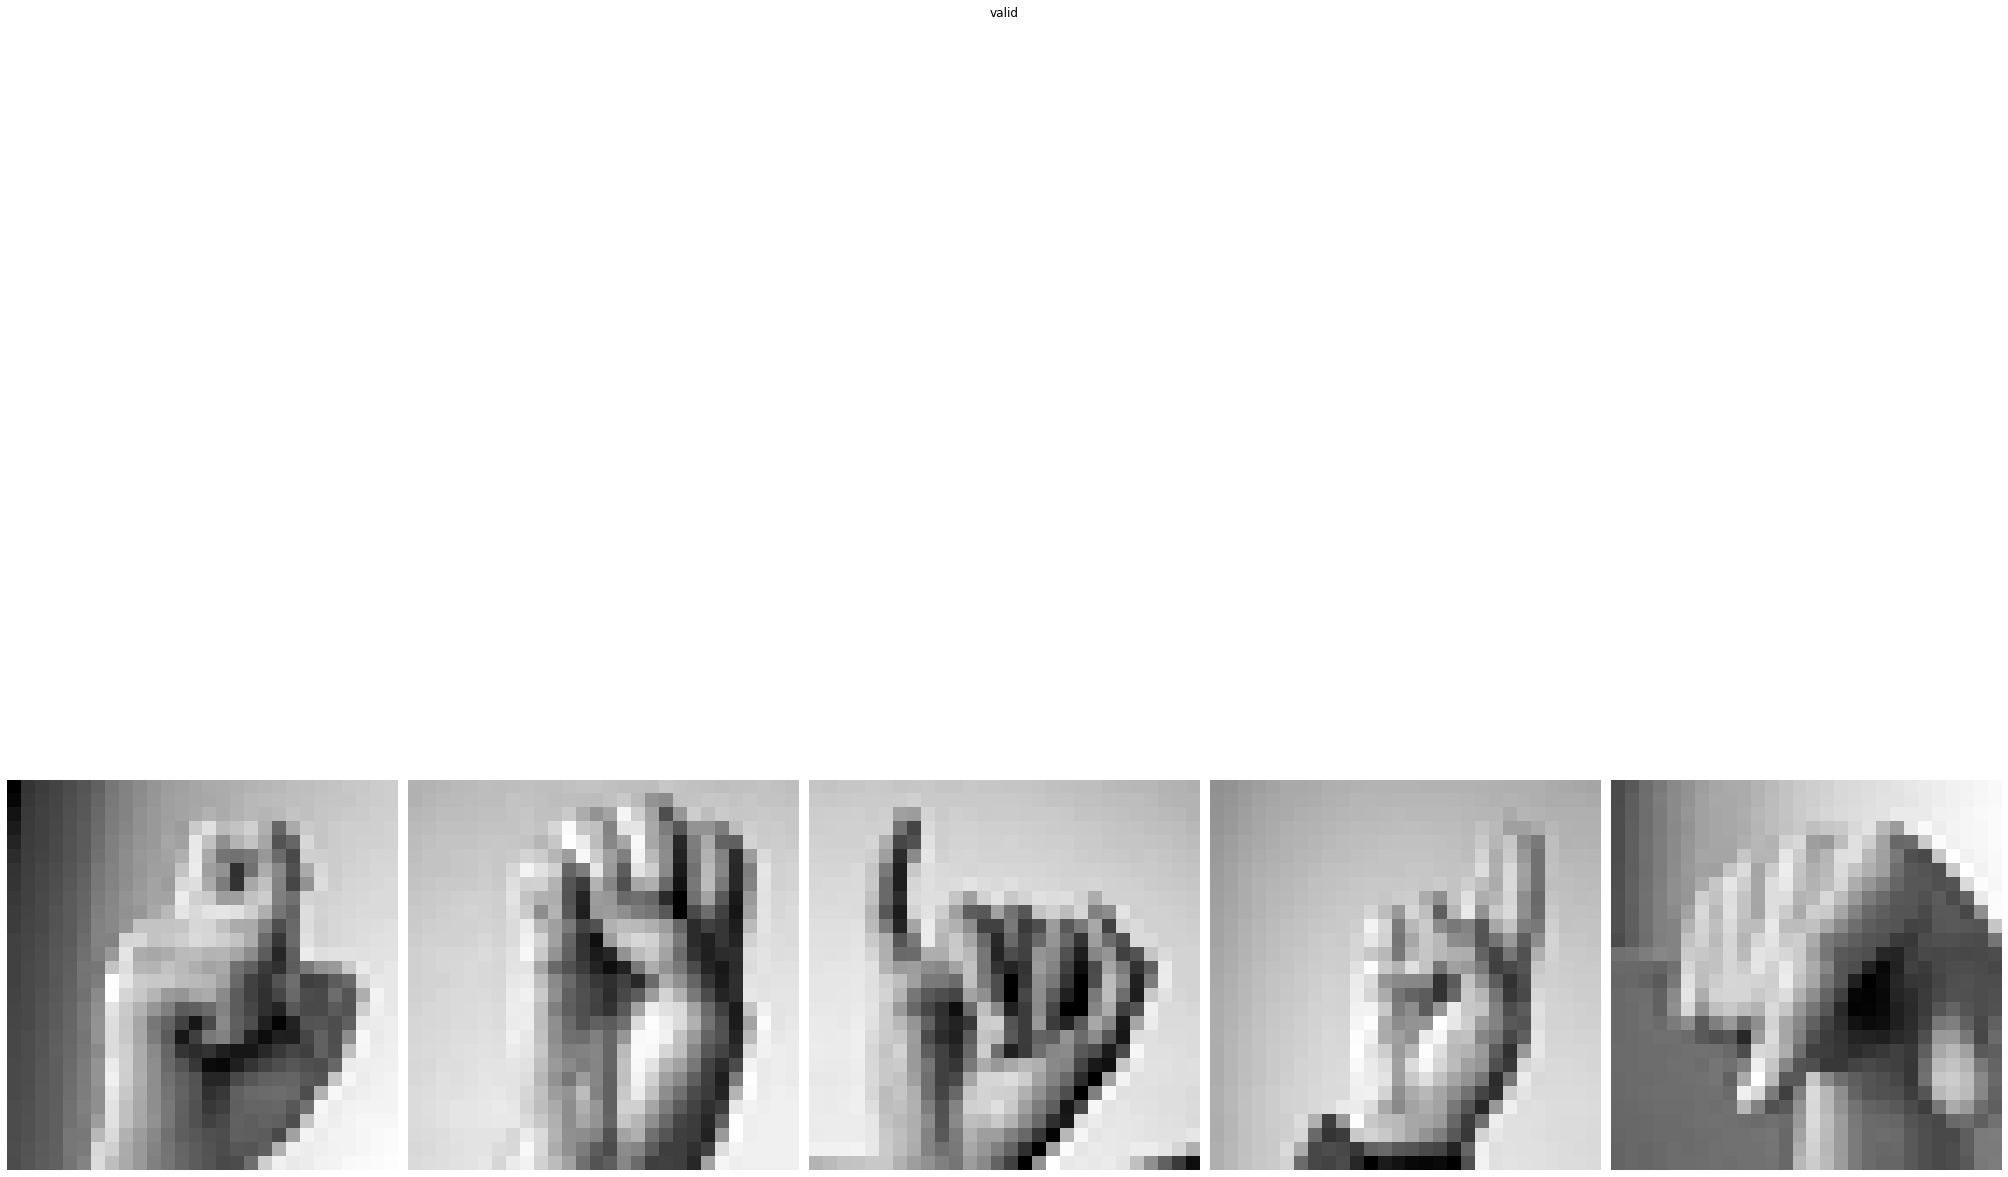

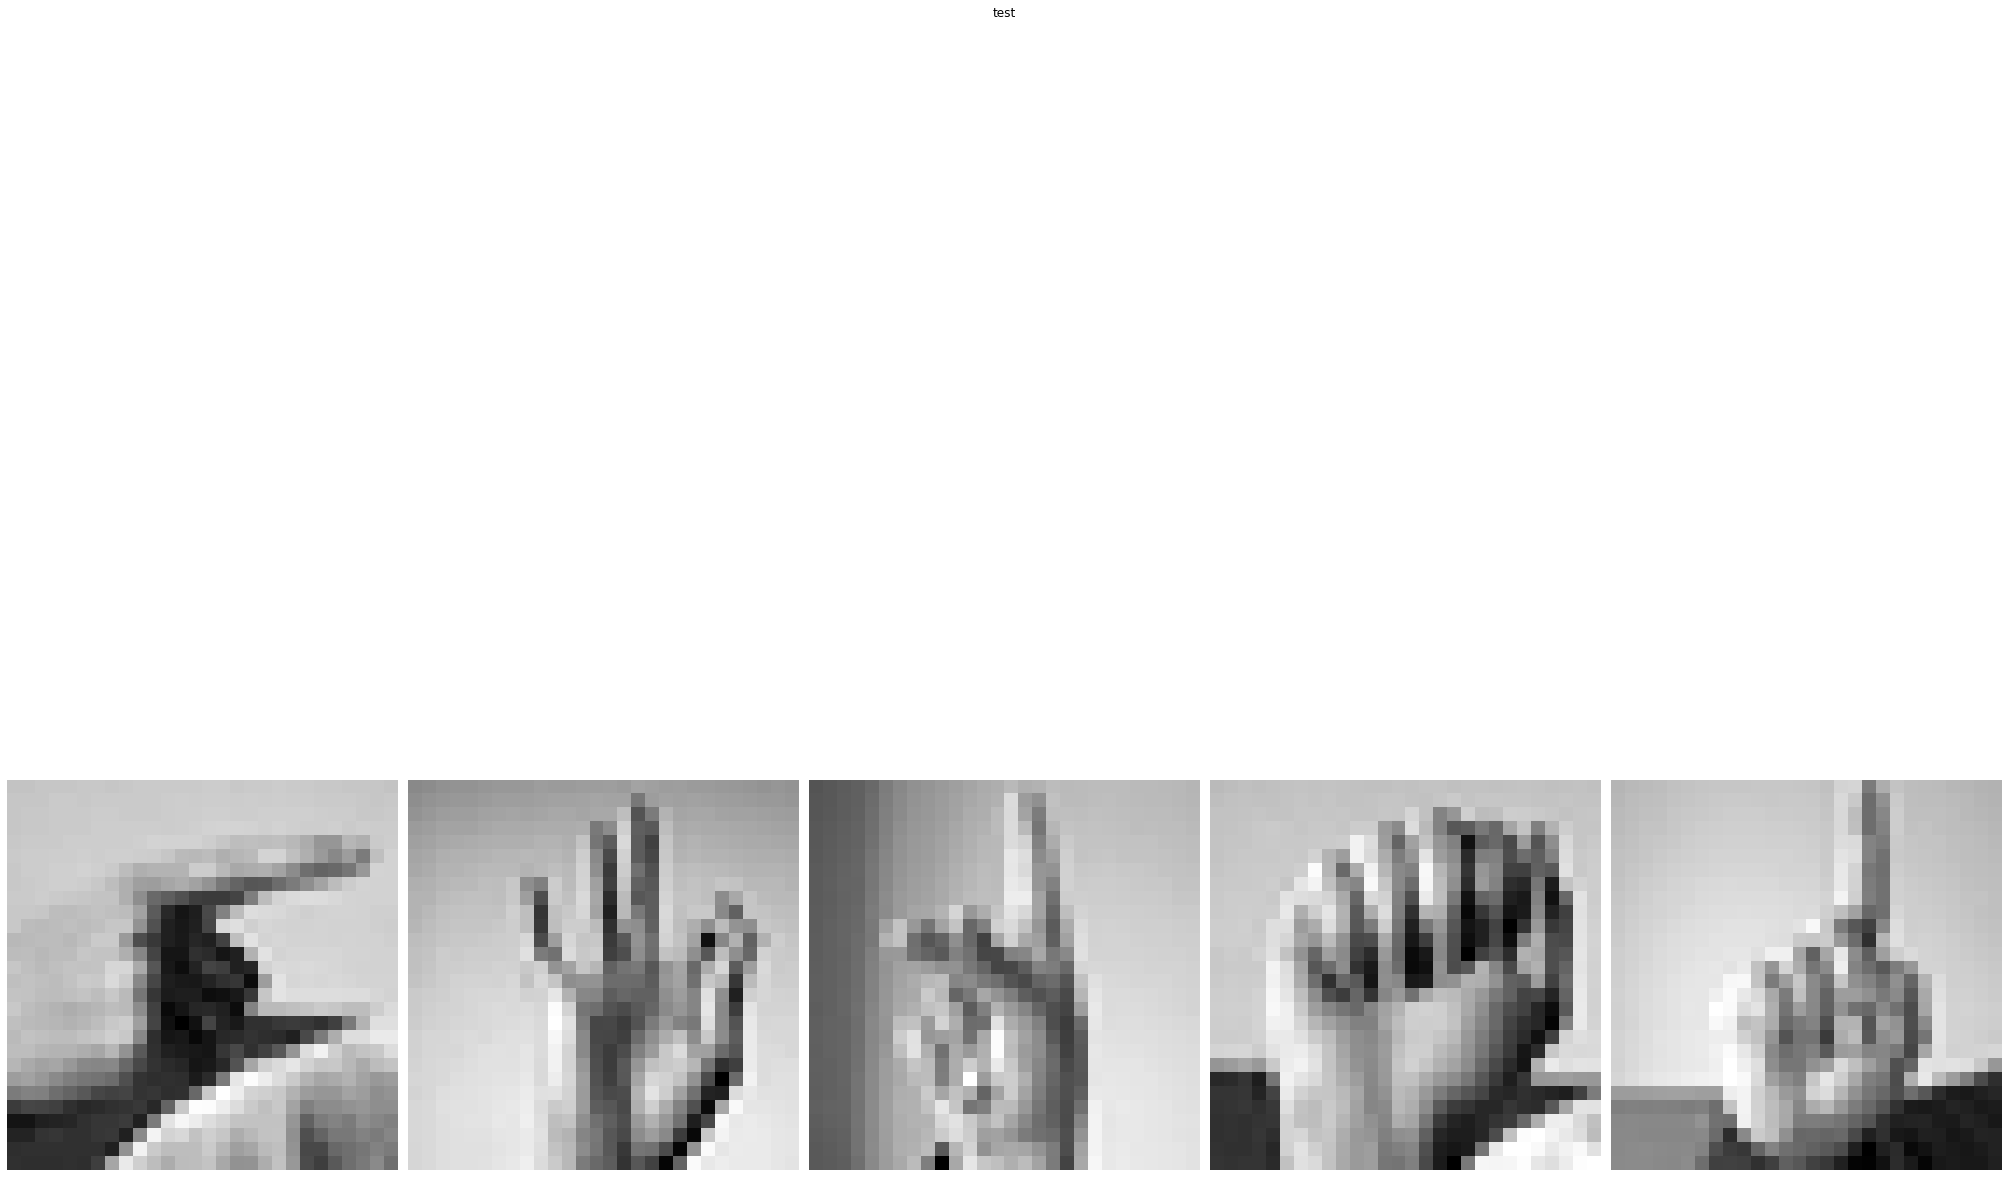

In [6]:
def plot_samples(images, sample_size, name):
    figure, axes = plt.subplots(1, sample_size, figsize=(28, 28))
    figure.suptitle(name)
    axes = axes.flatten()
    imgs = images[:sample_size]
    for img, ax in zip(imgs, axes):
        img = np.array(img)
        img.resize((28, 28))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_samples(train_images, 5, 'train')
plot_samples(valid_images, 5, 'valid')
plot_samples(test_images, 5, 'test')

Задание 2.
Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?


In [ ]:
l2_regularization = 1e-4

basic_model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(units=10, activation = 'softmax')
])

basic_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

basic_model.summary()
basic_model_history = basic_model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))
test_loss, test_acc = basic_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)